In [1]:
from visTools_v2.core_functions.operations.img_grad import conv2d
from visTools_v2.core_functions.edges import canny

In [284]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os


import numpy as np
import numpy.ma as ma
import math

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
def plot_line(im,n,c,kps,best_pts,extend=False):
    #n = np.round(n,2)
    if extend==True:
        xmin = kps[0,:].min()
        xmax = kps[0,:].max()

        ymin = kps[1,:].min()
        ymax = kps[1,:].max()
    else:
        xmin = kps[0,best_pts].min()
        xmax = kps[0,best_pts].max()

        ymin = kps[1,best_pts].min()
        ymax = kps[1,best_pts].max()
    
    if n[1]==0:
        f = lambda x:-c/n[0]
        yrange = np.linspace(ymin,ymax,100000)#kps[1,best_pts]
   
    elif n[0]==0:
        f = lambda x:-c/n[1]
        xrange = np.linspace(xmin,xmax,100000)#kps[0,best_pts]
        
    else:
        c = -c/n[1]
        n_ = -n[0]/n[1]
        f = lambda x: n_*x+c
        xrange = np.linspace(xmin,xmax,100000)#kps[0,best_pts]

    f = np.vectorize(f)
  

    if n[1]==0: 
        x = f(yrange)
        return x,yrange#x[keep],yrange[keep]
    
    elif n[0]==0:
        y = f(xrange)       
        return xrange,y
        
    else: 
        y = f(xrange)
        return xrange,y


In [4]:
def Reduce(im,k):
    for j in range(k):
        H,W = im.shape

        Dx = np.zeros((int((H+H%2)/2),H))
        Dx[np.arange(int((H+H%2)/2)),np.arange(0,H,2)]=1

        Dy = np.zeros((int((W+W%2)/2),W))
        Dy[np.arange(int((W+W%2)/2)),np.arange(0,W,2)]=1
        im = (Dx.dot(im)).dot(Dy.T)
    return im

def homog(kps):
    nKps = kps.shape[1]
    ones = np.ones(nKps)
    return np.vstack((kps,ones))


x,y = kps[:,xbnd&ybnd]
plt.scatter(x,y)
plt.imshow(im1.mask)

In [104]:
def IRLS_fit(l0,sig,kps,plot=False):
    sample = kps
    nSamples = kps.shape[1]
     
    ek = sample.T.dot(l0[:2])+l0[2]
    
    #sig = np.std(ek)
    
    w = 2*sig**2/(ek**2+sig**2)**2
        
    for i in range(1000):
  
        s = np.sum(w)
        m = (1/s)*np.sum(w*sample,axis=1)
        C = (1/s)*((w*(sample - m[:,np.newaxis])).dot((w*(sample - m[:,np.newaxis])).T))
        U,S,V = np.linalg.svd(C)
        n = V[-1]
        c = -n.dot(m)

        ek = sample.T.dot(n)+c
        w = 2*sig**2/(ek**2+sig**2)**2
        
        l=np.append(n,c)
        chg = np.sum((l0-l)**2)
        l0=l
        
        if chg<1e-10:
            if plot==True:print('IRLS stoped at {}'.format(i))
            break        
      
    o = ek**2/(ek**2+sig**2)
    if plot==True:print('Objective: {}'.format(np.sum(o))) 
    if plot==True:print('nSamples - 10: {}'.format(nSamples-10)) 
    if plot==True:print('Support: {}'.format(sum(w)))
    return n,c,w

In [145]:
'''
p - probability of being an inlier
k - number of samples
S - number of required trials
'''
def RANSAC(obj,P=.99,p=.1,min_pts=2,minInliers=100):
    
    def get_S(p=.1,P=.99,min_pts=2):
        return np.round(np.log(1-P)/(np.log(1-p**min_pts))).astype(int)

    S = get_S(p,P,min_pts)

    for i in range(S):
        nInliers = obj._next()
        
        if minInliers<nInliers:
            obj.retain()
            if minInliers>1000:
                break
                
    return obj.saved

In [146]:
def bestProposal(kps,lines,sig):
    o = []
    for t,l in enumerate(lines['lines']):
       
        ek = kps[:,lines['inliers'][t]].T.dot(l[:2])+l[2]
        #sig = np.std(ek)
        
        #o.append(np.sum((ek**2)/(sig**2+ek**2)))
        o.append(np.sum(2*sig**2/(ek**2+sig**2)**2))
    best_proposals = np.argsort(o)
    
    for key in lines.keys():
        lines[key] = [lines[key][i] for i in best_proposals]
    
    return lines
        
def isGoodLine(n,c,kps,sig):
    ek = kps.T.dot(n)+c
    #sig = np.std(ek)
    w = (2*sig**2)/(sig**2+ek**2)**2
    
    return np.sum(w)

In [8]:
def load_img(img):
    im = plt.imread(img)
    plt.imshow(im)
    plt.show()
    im = np.moveaxis(im,2,0)
    im = np.mean(im,axis=0)
    im = im[np.newaxis,np.newaxis,:,:]
    return im

In [225]:
import random
class random_lines_from_edgels:
    def __init__(self,mask,n_tan,th,lamb=10,ratio=(1,1),normal_only=False):
            self.lamb = lamb #controls search window for second random xk
            self.saved = {'lines':[],'nInliers':[],'inliers':[],'xk':[]}
            self.n_tan = n_tan
            self.mask = mask.copy()
            self.ls = None
            self.l = None
            self.xk = None
            
            row,col = np.argwhere(mask).T
            x=col
            y=row
            self.kps_bkup = self.kps = np.array([x,y])
                       
            nx = n_tan[0,row,col]
            ny = n_tan[1,row,col]
            d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)
            
            self.ls = np.array([nx,ny,d])
                
            self.idx = np.arange(self.ls.shape[1])
            self.idx = np.random.permutation(self.idx)
            self.th = th
            self.ratio=ratio
            self.normal_only=normal_only
            
    
           
    def retain(self):
        self.saved['lines'].append(self.l)
        self.saved['xk'].append(self.xk)
        self.saved['nInliers'].append(np.sum(self.inliers))
        self.saved['inliers'].append(self.inliers)
        pass
    
    def remove_kps(self,toremove):
        self.kps = self.kps[:,np.logical_not(toremove)]
        x,y = self.kps

        col=x
        row=y

        nx = self.n_tan[0,row,col]
        ny = self.n_tan[1,row,col]
        d = -(nx*x+ny*y)*np.sqrt(nx**2+ny**2)

        self.ls = np.array([nx,ny,d])

        self.idx = np.arange(self.ls.shape[1])
        self.idx = np.random.permutation(self.idx)
        self.th = th
        self.saved = {'lines':[],'nInliers':[],'inliers':[],'xk':[]}
    
    
    def _next_(self):
        idx1 = np.random.choice(self.idx)
        kp1 = self.kps[:,idx1]
        
        idx2 = np.random.choice(self.idx)
        kp2 = self.kps[:,idx2]
        
        self.xk = kp1
        
        self.l = np.cross(np.append(kp1,1),np.append(kp2,1))
        self.l = self.l/np.sum(self.l[:2]**2)
        
        self.inliers = (self.l[:2].dot(self.kps) + self.l[2] )**2 < self.th**2
        
        return np.sum(self.inliers)
        
    def _next(self):        
        idx = np.random.choice(self.idx)
        self.l = self.ls[:,idx]
        self.xk = self.kps[:,idx]
        if self.normal_only==False:

            #ratio = self.l[:2]/np.sum(self.l[:2]) + np.array([0.5,0.5])

            box,mask = get_box(self.xk,self.lamb,self.kps,ratio=self.ratio)

            nx,ny =self.n_tan[:,box[1],box[0]]

            d = np.sum((np.array([nx,ny])-self.l[:2][:,np.newaxis])**2,axis=0)

            p = 1- (d - d.min())/(d.max()-d.min())

            ins = np.sum(mask)

            idx2 = np.arange(ins)

            while np.sum(self.l)==0:
                idx2= np.random.choice(idx2,p=p/np.sum(p))
                xk2 = box[:,idx2]
                self.l = np.cross(np.append(self.xk,1),np.append(xk2,1))
                self.inliers*=mask

        e = (self.kps.T.dot(self.l[:2])+self.l[2])**2
        self.inliers = e<self.th**2
        
        
        return np.sum(self.inliers)

In [220]:
def get_box(xk,lamb,kps,ratio=(1,1),plot=False):
    v = np.array(ratio)
    xmax,ymax = np.clip((xk+lamb*v),None,(np.max(kps,axis=1))).astype(np.int)
    xmin,ymin = np.clip((xk-lamb*v),0,None).astype(np.int)


    xbnd = (kps[0,:]>xmin)&(kps[0,:]<xmax)
    ybnd = (kps[1,:]>ymin)&(kps[1,:]<ymax)
    if plot==True:
        x,y = kps[:,xbnd&ybnd]
        plt.scatter(x,y,s=0.1)
        pass
    return kps[:,xbnd&ybnd],xbnd&ybnd

In [296]:
class RobustFittingLine:
    def __init__(self,sig=1,nIter=20,min_kps=100,IRLS_th=0.4,**RANSAC_par):
        
        self.nIter = nIter
        self.sig = sig
        self.min_kps = min_kps
        self.IRLS_th = IRLS_th
        
        for k,v in RANSAC_par.items():
            setattr(self,k,v)
        
        self.fitted_lines = None
        self.random_lines = None
        
        self.Im = None
    
    def fit(self,Im=None,y=None):
        self.Im = Im
        fitted_lines = []
        h,w = self.Im.mask.shape
        extent = [0,w,h,0]
        
        random_lines = random_lines_from_edgels(mask=im1.mask,n_tan =im1.get_tan(),
                                                th=self.RANSAC_th,lamb=self.RANSAC_lamb,
                                                ratio=self.RANSAC_ratio,normal_only=False)
        for j in range(self.nIter):

            lines = RANSAC(random_lines,P=self.RANSAC_P,p=self.RANSAC_p,minInliers=self.RANSAC_minInliers)


            best_lines = bestProposal(random_lines.kps,lines,self.sig)

            n,c,w = IRLS_fit(best_lines['lines'][-1],self.sig,random_lines.kps[:,best_lines['inliers'][-1]])
            
            
            inliers = w>self.IRLS_th
            inliers = random_lines.kps[:,best_lines['inliers'][-1]][:,inliers]
            
            best_lines['inliers'][-1][best_lines['inliers'][-1]==True] = w>self.IRLS_th
            
            fitted_lines.append({'line':(n,c),'inliers':random_lines.kps[:,best_lines['inliers'][-1]]})

            
            random_lines.remove_kps(best_lines['inliers'][-1])
            if random_lines.kps.shape[1]<self.min_kps:
                break

        
        self.fitted_lines=fitted_lines
        self.random_lines=random_lines
    
    def plot(self):
        colors = iter(cm.rainbow(np.linspace(0, 1, self.nIter)))

        plt.figure(figsize=(10,16))
        for line in self.fitted_lines:
            color = next(colors)
            
            n,c = line['line']

            '''Plot line after IRLS'''
            xrange,y = plot_line(self.Im.mask,n,c,self.random_lines.kps_bkup,
                                 line['inliers'][0],extend=True)
            plt.scatter(xrange,y,s=1,c=color)
            
            x,y = line['inliers']
            plt.scatter(x,y,s=1,c=color)
            plt.imshow(self.Im.mask,**{'cmap':'gray'})
        #plt.show()
        

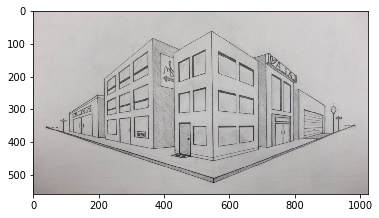

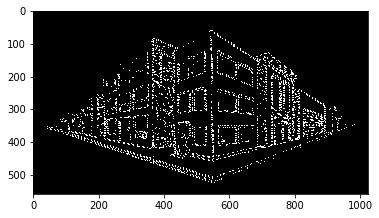

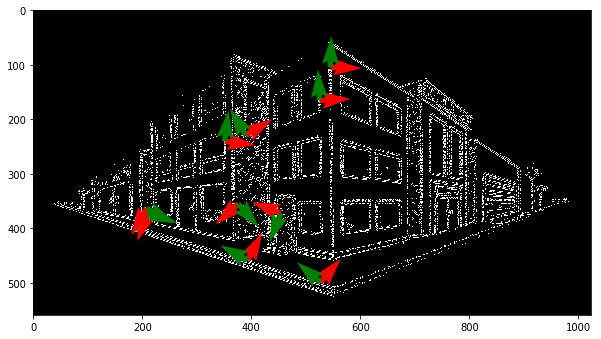

In [243]:
im = load_img('img/2viewp.jpg')
im1 = canny(sharp=True,
             blur=True,h=3,w=3,sig=1,th=.1,Red=0)
im1.fit(im)
im1.plot()
im1.vector_field(figsize=(10,16),tan=True)

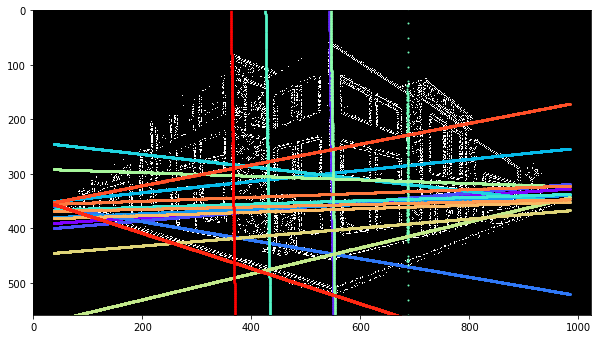

In [298]:
RANSAC_par = {
    'RANSAC_P':.99,
    'RANSAC_p':.1,
    'RANSAC_minInliers':100,
    'RANSAC_th':30,
    'RANSAC_lamb':50,
    'RANSAC_ratio':(1,1),
    }

model = RobustFittingLine(sig=1,nIter=20,**RANSAC_par)
model.fit(im1)
model.plot()